In [26]:
import sys
import json
sys.path.append("/global/homes/s/seanjx/gigalens/src")

import numpy as np
from matplotlib import pyplot as plt
from jax import numpy as jnp

from astropy.io import fits
from astropy.visualization import simple_norm

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Plots import lens_plot
import lenstronomy.Util.simulation_util as sim_util
from lenstronomy.Data.imaging_data import ImageData
import lenstronomy.Plots.model_plot as model_plot
from lenstronomy.Util import util

from gigalens.jax.model import ForwardProbModel, BackwardProbModel
from gigalens.jax.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.model import PhysicalModel

import myfunctions

In [15]:
#load observation data, do masking
f=fits.open('psf246.fits') 
psf=jnp.array(f[0].data)

observed_img = np.load("cutout246.npy")

f=fits.open('final_96_drz.fits')
background_rms=0.00788315
exp_time=f[0].header["EXPTIME"]
deltaPix = f[0].header["D002SCAL"]
numPix = np.shape(observed_img)[0]

In [5]:
path = "output/"+"246_2024-07-25 02:08:10.888891"
prior, phys_model, phys_model_Forward, SingleSources = myfunctions.readJson(path+"/prior.json")[0:4]
err_map = np.load(path+"/err_map.npy")

sim_config = SimulatorConfig(deltaPix=deltaPix, numPix=numPix, supersample=1, kernel=psf)
lens_sim = LensSimulator(phys_model, sim_config, bs=1)
try: 
    inputFile = open(path+"/bestHMC.json")
    best_HMC = json.load(inputFile)
    print("HMC loaded")
    MAPorHMC = "HMC"
except: 
    prob_model = BackwardProbModel(prior, observed_img, err_map, background_rms=background_rms, exp_time=exp_time)
    best = np.load(path+"/best.npy")
    best_HMC = prob_model.bij.forward(best.tolist()[0])
    MAPorHMC = "MAP"
    print("MAP loaded")

HMC loaded


In [6]:
priorObjects = myfunctions.getPriors(phys_model)
numParams = myfunctions.countParameters(phys_model)
print(numParams,priorObjects)

47 (['EPL', 'SHEAR'], ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'], ['SHAPELETS', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'])


In [7]:
for ii, thing in enumerate(best_HMC):
    for iii, thing2 in enumerate(thing):
        for iv in thing2:
            best_HMC[ii][iii][iv] = float(best_HMC[ii][iii][iv])

In [8]:
plt.style.use('default')
simulated, coeffs = lens_sim.lstsq_simulate(best_HMC,jnp.array(observed_img),err_map)

kwargs_data = sim_util.data_configure_simple(numPix*2, deltaPix)
data = ImageData(**kwargs_data)
_coords = data
lensModel = LensModel(lens_model_list=priorObjects[0])
kwargs_lens = best_HMC[0]
print(kwargs_lens)
extent = (-numPix/2*deltaPix, numPix/2*deltaPix, -numPix/2*deltaPix, numPix/2*deltaPix)
scale_length = 1 #arcsec

def convertEllipticity(e1, e2):
    phi = jnp.arctan2(e2, e1) / 2
    c = jnp.minimum(jnp.sqrt(e1 ** 2 + e2 ** 2), 0.9999)
    q = (1 - c) / (1 + c)
    return float(q), float(phi)

print(best_HMC[0][0]['e1'],best_HMC[0][0]['e2'])
print(convertEllipticity(best_HMC[0][0]['e1'],best_HMC[0][0]['e2']))

2024-08-08 10:55:12.071712: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{} for conv (f32[1,142,110,110]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,142,110,110]{3,2,1,0}, f32[142,1,27,27]{3,2,1,0}), window={size=27x27 pad=13_13x13_13}, dim_labels=bf01_oi01->bf01, feature_group_count=142, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
E0808 10:55:12.276457 2275845 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0808 10:55:12.937461 2275845 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0808 10:55:13.57

[{'theta_E': 2.7270870208740234, 'gamma': 2.40407133102417, 'e2': 0.16737186908721924, 'e1': 0.025479227304458618, 'center_y': -0.05275706201791763, 'center_x': 0.09405598044395447}, {'gamma2': 0.03578665107488632, 'gamma1': -0.05211759731173515}]
0.025479227304458618 0.16737186908721924
(0.7104248404502869, 0.709862470626831)


In [9]:
mass = best_HMC[0]
lens_light = best_HMC[1]
source_light = best_HMC[2]
for ii, thing in enumerate(lens_light):
    thing["Ie"] = float(coeffs[0][ii]*1/deltaPix**2)

counter = ii+1
for ii, thing in enumerate(source_light):
    if priorObjects[2][ii] == "SHAPELETS":
        n_max = phys_model.getProfiles()[2][ii].n_max
        #n_max = 5
        n_layers = int((n_max + 1) * (n_max + 2) / 2)
        decimal_places = len(str(n_layers))
        amps = []
        for iii in range(n_layers):
            amps.append(f"amp{str(iii).zfill(decimal_places)}")
            thing[amps[iii]]=np.array([coeffs[0][counter]*1/deltaPix**2])
            counter = counter + 1
    else:
        thing["Ie"] = float(coeffs[0][counter]*1/deltaPix**2)
        counter = counter + 1

lens_sim_deconstructed = LensSimulator(phys_model_Forward, sim_config, bs=1)

sourcesimulated = lens_sim_deconstructed.simulate([[], [], source_light])
masssimulated = lens_sim_deconstructed.simulate([mass, [], source_light])
lenssimulated = lens_sim_deconstructed.simulate([[], lens_light, []])

individualSourceSimulations = []
for ii, source in enumerate(source_light):
    OneSourceModel = LensSimulator(SingleSources[ii], sim_config, bs=1)
    individualSourceSimulations.append(OneSourceModel.simulate([mass, [], [source]]))    


In [10]:
print(best_HMC)
print(phys_model.getProfiles()[2][0].n_max,)#phys_model.getProfiles()[2][1].n_max)

[[{'theta_E': 2.7270870208740234, 'gamma': 2.40407133102417, 'e2': 0.16737186908721924, 'e1': 0.025479227304458618, 'center_y': -0.05275706201791763, 'center_x': 0.09405598044395447}, {'gamma2': 0.03578665107488632, 'gamma1': -0.05211759731173515}], [{'n_sersic': 6.131049156188965, 'e2': -0.2653387784957886, 'e1': 0.008192211389541626, 'center_y': -0.04235822707414627, 'center_x': 0.22286364436149597, 'R_sersic': 0.980766773223877, 'Ie': 1.8005131483078003}, {'n_sersic': 5.060711860656738, 'e2': -0.0024334341287612915, 'e1': 0.1832471489906311, 'center_y': -0.04987884312868118, 'center_x': -0.08559736609458923, 'R_sersic': 1.782529354095459, 'Ie': 15.408323287963867}, {'n_sersic': 2.424811363220215, 'e2': 0.2754998207092285, 'e1': -0.27709686756134033, 'center_y': 0.07626461982727051, 'center_x': 3.1004769802093506, 'R_sersic': 0.1789378970861435, 'Ie': 34.459041595458984}, {'n_sersic': 2.918445110321045, 'e2': -0.18761016428470612, 'e1': -0.03217718005180359, 'center_y': -2.9221420288

<>:24: SyntaxWarning: invalid escape sequence '\c'
<>:24: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_2275845/3104698093.py:24: SyntaxWarning: invalid escape sequence '\c'
  plt.title(f"Residuals $\chi^2=${myfunctions.trunc(np.round(HMCchi,2),2)}")


1.1696326


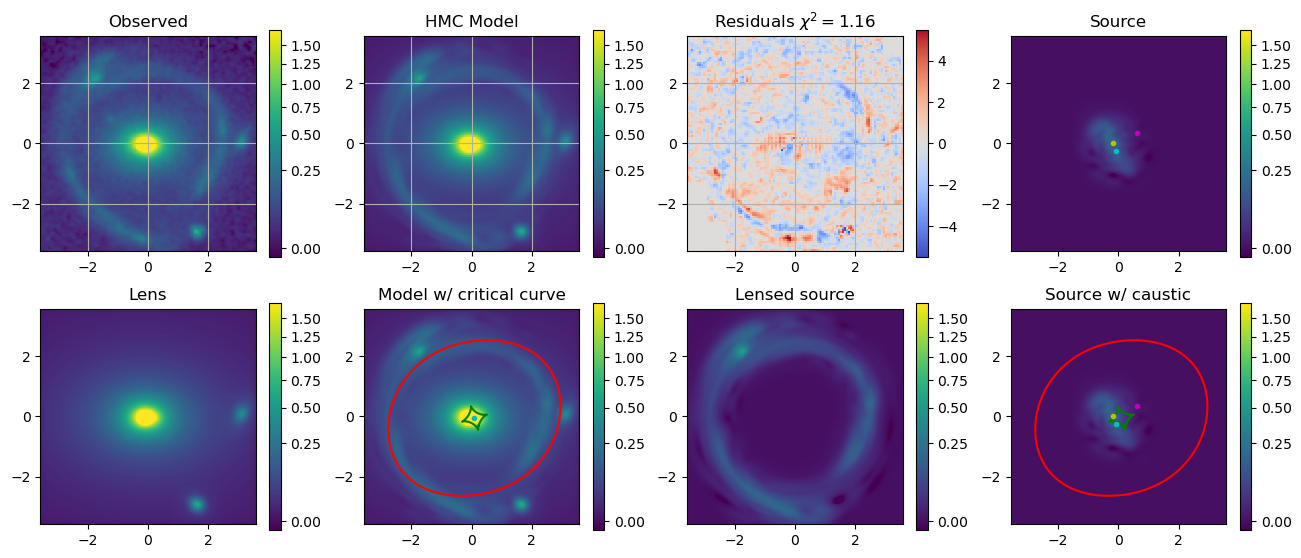

In [20]:
plt.figure(figsize=(16, 6.5))
colors = ["c.","m.","y.","w.","r.","k."]
norm = simple_norm(observed_img, 'sqrt', percent=99.)

resid = jnp.array(observed_img) - simulated
chi2 = np.sum((resid/err_map)**2)
dof = len(np.reshape(err_map,-1)[np.reshape(err_map,-1)<1])-numParams
HMCchi = chi2/dof

plt.subplot(241)
plt.imshow(observed_img, norm=norm, extent=extent,origin='lower', cmap='viridis')
plt.title("Observed")
plt.colorbar()
plt.grid(which='major')

ax = plt.subplot(242)
plt.imshow(simulated, norm=norm, extent=extent,origin='lower', cmap='viridis')
plt.title(MAPorHMC+" Model")
plt.colorbar()
plt.grid(which='major')

plt.subplot(243)
plt.imshow(resid/err_map, cmap='coolwarm', extent=extent, origin='lower',interpolation='none', vmin=-5.5, vmax=5.5)
plt.title(f"Residuals $\chi^2=${myfunctions.trunc(np.round(HMCchi,2),2)}")
plt.colorbar()
plt.grid(which='major')

plt.subplot(244)
for ii in range(0,len(source_light)):
    plt.plot(source_light[ii]["center_x"],source_light[ii]["center_y"],colors[ii])
plt.imshow(sourcesimulated, norm=norm, extent=extent, origin='lower', cmap='viridis')
plt.title("Source")
plt.colorbar()

plt.subplot(245)
plt.imshow(lenssimulated, norm=norm, extent=extent, origin='lower', cmap='viridis')
plt.title("Lens")
plt.colorbar()

ax = plt.subplot(246)
lens_plot.caustics_plot(ax, _coords, lensModel, kwargs_lens, fast_caustic=True, color_crit='red', color_caustic='green',)
plt.imshow(simulated, norm=norm, extent=extent,origin='lower', cmap='viridis')
for ii in range(0,len(mass)):
    try:
        plt.plot(mass[ii]["center_x"],mass[ii]["center_y"],colors[ii])
    except:
        pass
plt.title("Model w/ critical curve")
plt.colorbar()

plt.subplot(247)
plt.imshow(masssimulated, norm=norm, extent=extent, origin='lower', cmap='viridis')
plt.title("Lensed source")
plt.colorbar()

ax = plt.subplot(248)
lens_plot.caustics_plot(ax, _coords, lensModel, kwargs_lens, fast_caustic=True, color_crit='red', color_caustic='green',)
for ii in range(0,len(source_light)):
    plt.plot(source_light[ii]["center_x"],source_light[ii]["center_y"],colors[ii])
plt.imshow(sourcesimulated, norm=norm, extent=extent, origin='lower', cmap='viridis')
plt.title("Source w/ caustic")
plt.colorbar()

plt.savefig(path+"/"+MAPorHMC+"output.png",)#transparent=True)
print(HMCchi)

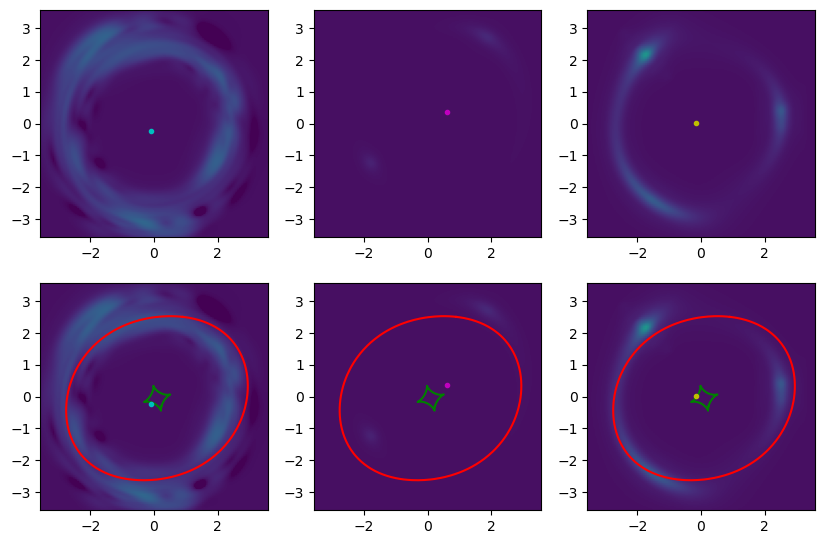

In [30]:
plt.figure(figsize=(10,6.5))

for ii, source in enumerate(source_light):
    ax = plt.subplot(2,len(source_light),ii+1)
    plt.imshow(individualSourceSimulations[ii], norm=norm, extent=extent, origin='lower', cmap='viridis')
    plt.plot(source_light[ii]["center_x"],source_light[ii]["center_y"],colors[ii])
for ii, source in enumerate(source_light):
    ax = plt.subplot(2,len(source_light),ii+1+len(source_light))
    lens_plot.caustics_plot(ax, _coords, lensModel, kwargs_lens, fast_caustic=True, color_crit='red', color_caustic='green',)
    plt.plot(source_light[ii]["center_x"],source_light[ii]["center_y"],colors[ii])
    plt.imshow(individualSourceSimulations[ii], norm=norm, extent=extent, origin='lower', cmap='viridis')

plt.savefig(path+"/"+MAPorHMC+"deconstructed.png",)#transparent=True)

<>:11: SyntaxWarning: invalid escape sequence '\c'
<>:11: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_2045486/3492142694.py:11: SyntaxWarning: invalid escape sequence '\c'
  plt.title(f"Residuals $\chi^2=${myfunctions.trunc(np.round(HMCchi,2),2)}")


-0.014320014
-0.0061323955


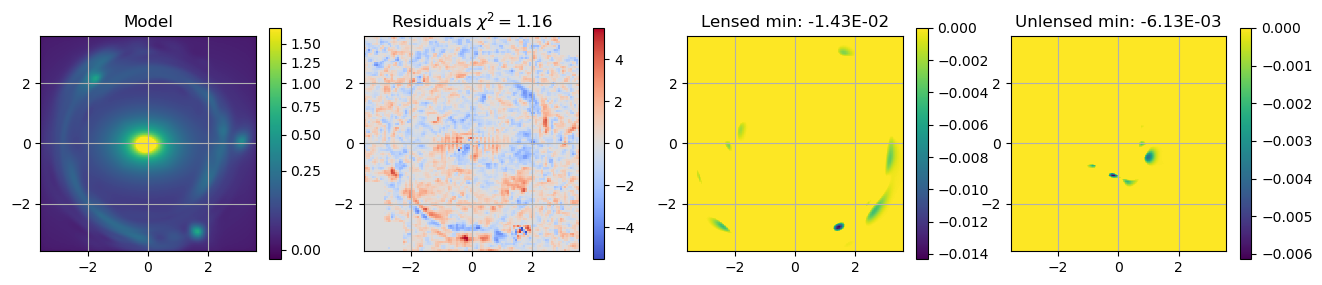

In [31]:
plt.figure(figsize=(16,3))

ax = plt.subplot(141)
plt.imshow(simulated, norm=norm, extent=extent,origin='lower', cmap='viridis')
plt.title("Model")
plt.colorbar()
plt.grid(which='major')

plt.subplot(142)
plt.imshow(resid/err_map, cmap='coolwarm', extent=extent, origin='lower',interpolation='none', vmin=-5.5, vmax=5.5)
plt.title(f"Residuals $\chi^2=${myfunctions.trunc(np.round(HMCchi,2),2)}")
plt.colorbar()
plt.grid(which='major')

plt.subplot(143)
plt.imshow(masssimulated, vmax=0, extent=extent, origin='lower')
plt.colorbar()
plt.grid(which='major')
plt.title(f"Lensed min: {np.min(masssimulated):.2E}")
print(np.min(masssimulated))

plt.subplot(144)
plt.imshow(sourcesimulated, vmax=0, extent=extent, origin='lower')
plt.colorbar()
plt.grid(which='major')
plt.title(f"Unlensed min: {np.min(sourcesimulated):.2E}")
print(np.min(sourcesimulated))

plt.savefig(path+"/"+MAPorHMC+"negativedetection.png")

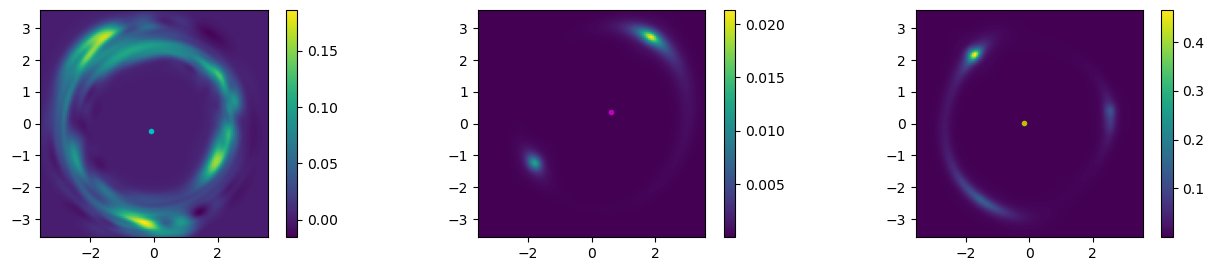

In [32]:
plt.figure(figsize=(16,6.5))

for ii, source in enumerate(source_light):
    ax = plt.subplot(2,len(source_light),ii+1)
    plt.imshow(individualSourceSimulations[ii], extent=extent, origin='lower')
    plt.plot(source_light[ii]["center_x"],source_light[ii]["center_y"],colors[ii])
    plt.colorbar()

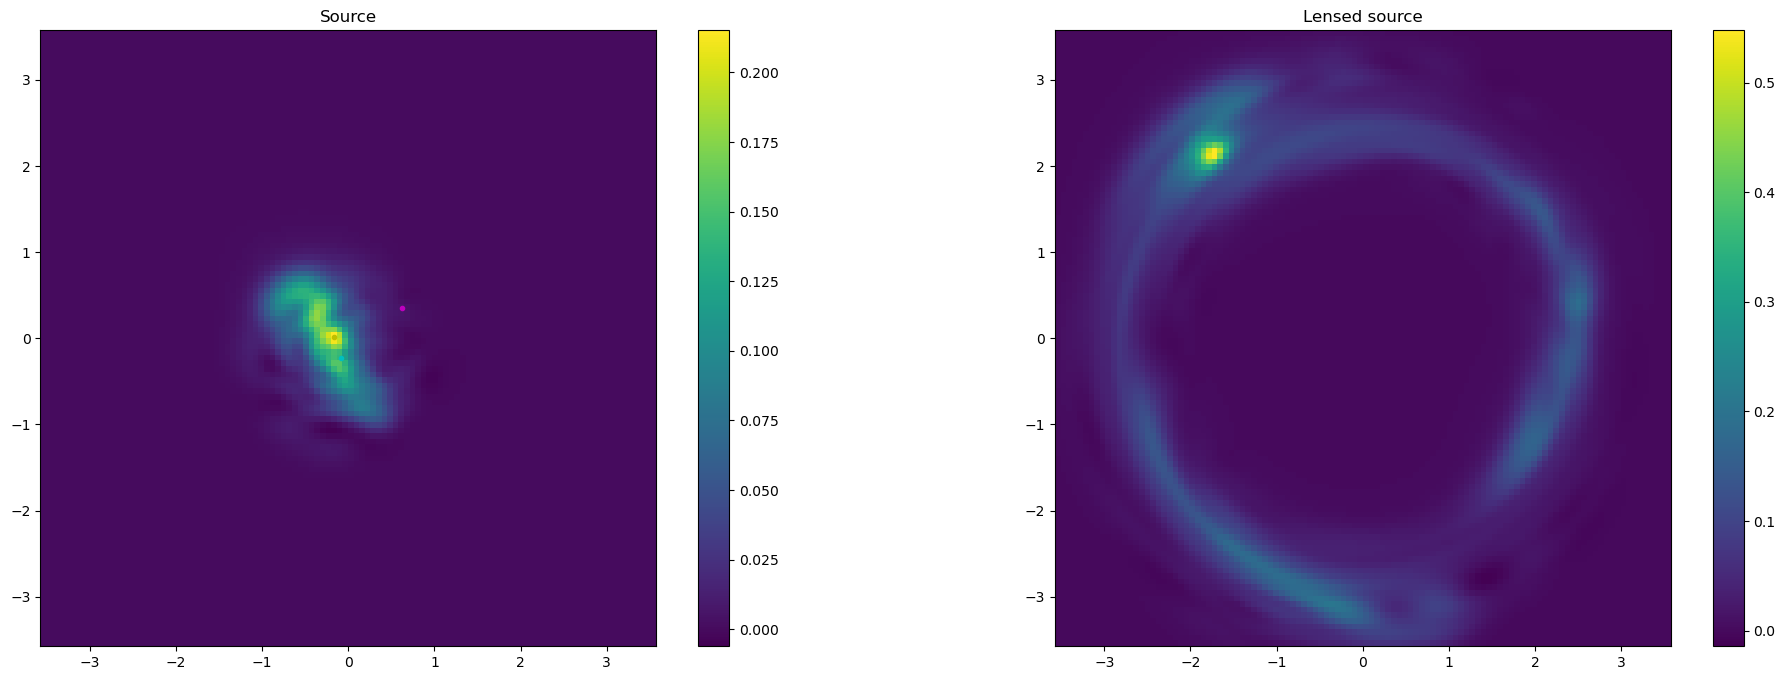

In [33]:
plt.figure(figsize=(24,8))
plt.subplot(121)
for ii in range(0,len(source_light)):
    plt.plot(source_light[ii]["center_x"],source_light[ii]["center_y"],colors[ii])
plt.imshow(sourcesimulated, extent=extent, origin='lower', cmap='viridis')
plt.title("Source")
plt.colorbar()

plt.subplot(122)
plt.imshow(masssimulated, extent=extent, origin='lower', cmap='viridis')
plt.title("Lensed source")
plt.colorbar()

plt.savefig(path+"/"+MAPorHMC+"source.png",)#transparent=True)

<>:18: SyntaxWarning: invalid escape sequence '\l'
<>:18: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_2045486/1558652259.py:18: SyntaxWarning: invalid escape sequence '\l'
  plt.title("$\log\kappa$")


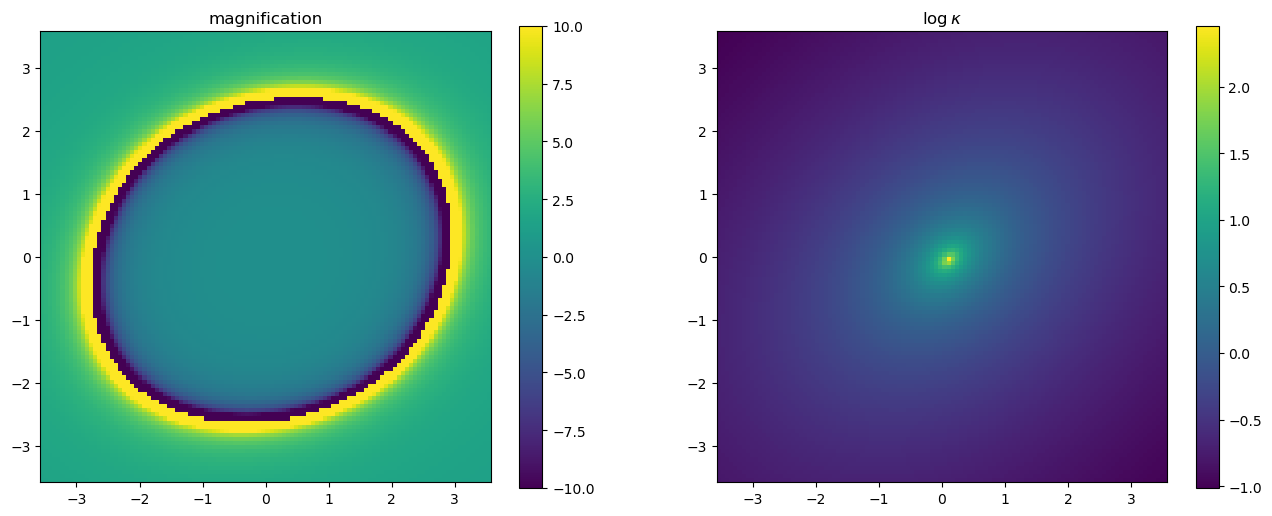

In [34]:
x_grid, y_grid = util.make_grid(numPix=numPix, deltapix=deltaPix)

mag_grid = lensModel.magnification(x_grid, y_grid, kwargs_lens)
mag2d = util.array2image(mag_grid)

kappa_grid = lensModel.kappa(x_grid, y_grid, kwargs_lens)
kappa2d = util.array2image(kappa_grid)

plt.figure(figsize=(16,6))
plt.subplot(121)
plt.imshow(mag2d, origin='lower',extent=extent, vmin=-10, vmax=10)
plt.colorbar()
plt.title("magnification")

plt.subplot(122)
plt.imshow(np.log10(kappa2d), origin='lower',extent=extent)
plt.colorbar()
plt.title("$\log\kappa$")
plt.savefig(path+"/"+MAPorHMC+"magkapa.png",)#transparent=True)

In [35]:
from lenstronomy.Cosmo.lens_cosmo import LensCosmo

lensModelNoShear = LensModel(lens_model_list=[priorObjects[0][0]])
mag_gridNoShear = lensModelNoShear.magnification(x_grid, y_grid, [kwargs_lens[0]])
mag2dNoShear = util.array2image(mag_gridNoShear)

area=np.count_nonzero(np.multiply(mag2dNoShear<1,kappa2d))*deltaPix**2
print('Area', area, 'arcsec**2')

z_lens, z_source= 1.092, 2.35
lenscosmo = LensCosmo(z_lens, z_source)
sigma_crit = lenscosmo.sigma_crit
dd = lenscosmo.dd
print(f"Critical surface density (sigma_crit): {sigma_crit} M_sun/Mpc^2")
realArea=dd**2*area*(np.pi/180/3600)**2
mass=realArea*sigma_crit
print('dd', dd)
print('Area', realArea)
print('Mass:{:.4e}'.format(mass))

Area 23.207925000000003 arcsec**2
Critical surface density (sigma_crit): 2566981440993538.5 M_sun/Mpc^2
dd 1729.5587317230543
Area 0.001631761470957105
Mass:4.1887e+12


In [36]:
lenscosmo.dd, lenscosmo.ds, lenscosmo.dds

(1729.5587317230543, 1726.588494701713, 646.5177882048082)

/tmp/ipykernel_2045486/1240959141.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.multiply(mag2dNoShear<1,kappa2d)), origin='lower',extent=extent)


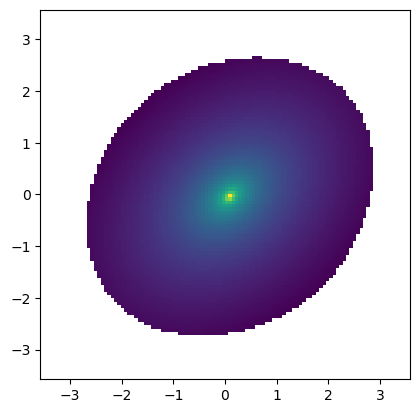

In [37]:
plt.imshow(np.log10(np.multiply(mag2dNoShear<1,kappa2d)), origin='lower',extent=extent)

In [38]:
print(np.sum(np.multiply(mag2dNoShear<1,kappa2d))/np.count_nonzero(np.multiply(mag2d<1,kappa2d)))

0.9743075825250894


In [39]:
print(np.sum(np.multiply(mag2dNoShear<1,kappa2d)))

5360.640319053042


Text(0.5, 1.0, 'magnification')

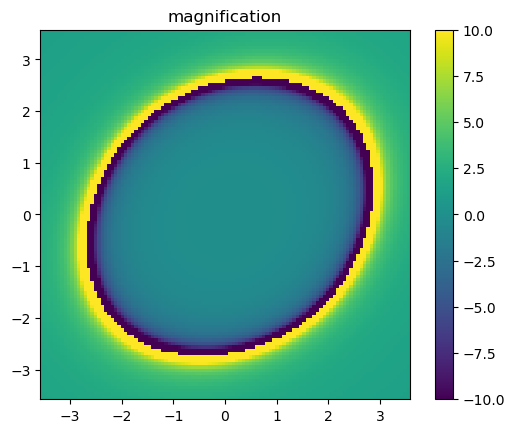

In [40]:
plt.imshow(mag2dNoShear, origin='lower',extent=extent, vmin=-10, vmax=10)
plt.colorbar()
plt.title("magnification")
